<a href="https://colab.research.google.com/github/huseyin-yigit-ulker/Machine_learning_assignments/blob/main/ass3/Assignment_3_H%C3%BCseyin_Yi%C4%9Fit_%C3%9Clker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment-3

**Due Date:** 14.12.2022 

---------------------------------------

**Instructor:** Erkut Erdem

**TA:** Sibel Kapan

---------------------------------------

**Student:** Hüseyin Yiğit Ülker

**Github Classroom:** https://classroom.github.com/a/Wv6S7qnL



## Part I: Theory Questions

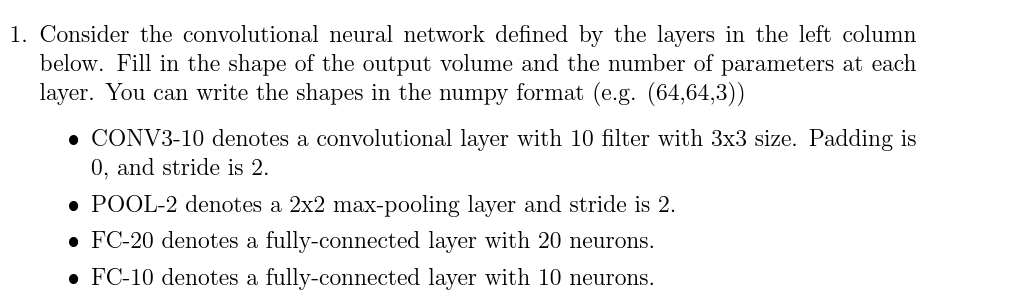

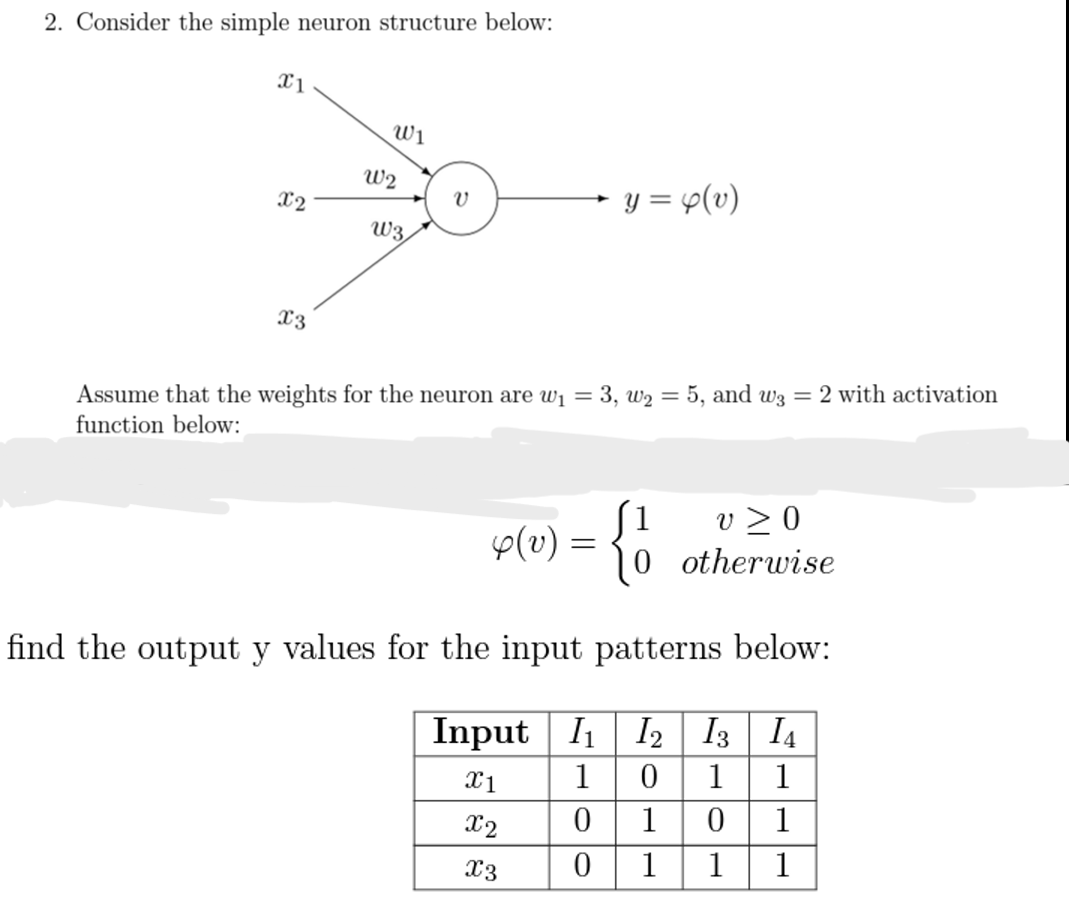

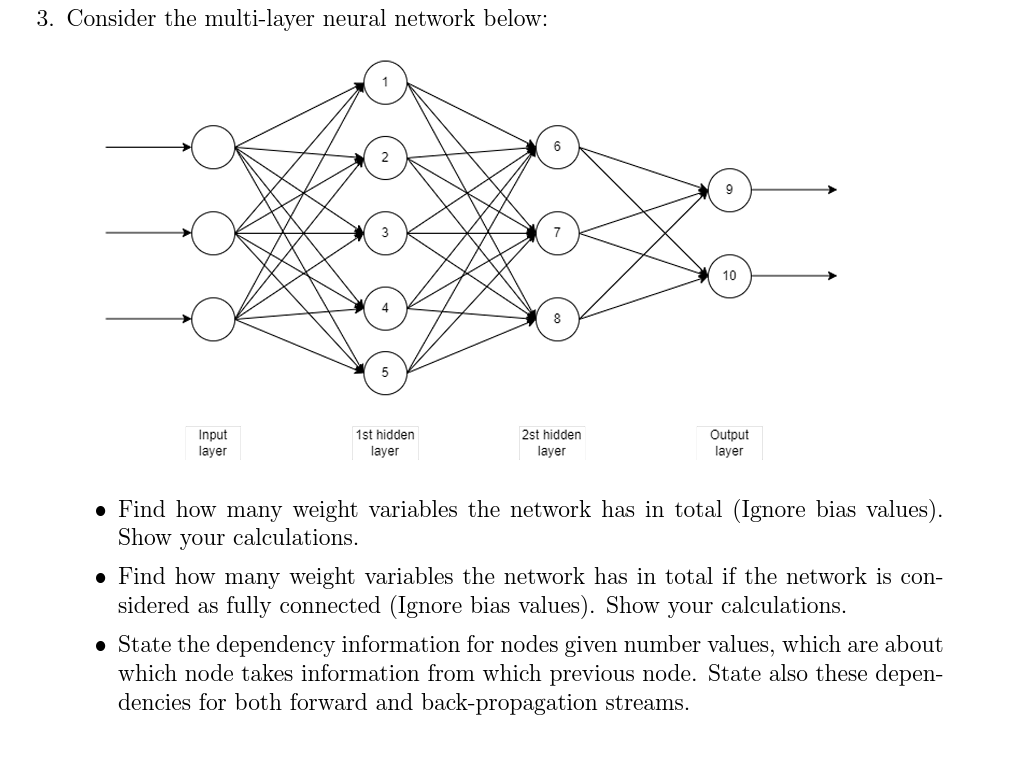

## Part II: Classification of Flower Species using Neural Network


### Dataset Upload

Dataset uploaded from Drive or local

In [3]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
data_path = 'https://drive.google.com/file/d/1PyTLK4lCJR7kvntCTxyiTSU5vegDw2dz/view?usp=sharing'
  
# to get the id part of the file
id = data_path.split("/")[-2]
 

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flowers.zip')  

In [ ]:
! unzip flowers.zip -d data

In [6]:
import os
import numpy as np
import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.special import softmax
from numpy import argmax
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix

In [7]:
ROOT_PATH = '/content/data/flowers/'
training_path = f'{ROOT_PATH}/train'
test_path = f'{ROOT_PATH}/test'

In [8]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
jitter=(0.1,0.1,0.1)

In [7]:
mean_g = [0.554]
std_g = [0.231]
jitter_g=(0.1)

In [9]:
image_size = 32      # 32x32, 64x64, 128x128
batch_size = 128

In [19]:
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean_g,std_g)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(jitter_g),    # about saturation brightness vs.
    transforms.ToTensor(),
      transforms.Grayscale(),
    transforms.Normalize(mean_g,std_g),
    transforms.RandomErasing()      #randomly erasing pixels 
])

In [10]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)

In [11]:
test_dataset = datasets.ImageFolder(test_path, transform=main_transform)

In [ ]:
for i in os.listdir(training_path):
    print(i+" class has "+str(len(os.listdir(training_path+"/"+i)))+" data")

sunflower class has 1400 data
dandelion class has 1400 data
rose class has 1400 data
daisy class has 1400 data
lotus class has 1400 data
bellflower class has 1400 data
tulip class has 1400 data


In [ ]:
for i in os.listdir(test_path):
    print(i+" class has "+str(len(os.listdir(test_path+"/"+i)))+" data")

sunflower class has 200 data
dandelion class has 200 data
rose class has 200 data
daisy class has 200 data
lotus class has 200 data
bellflower class has 200 data
tulip class has 200 data


###Multi Layer Neural Network

In [ ]:
test_dataset[0][1]

0

In [ ]:
def split(data):
  x=[]
  y=[]
  for i in data:
    y_=np.zeros((7,))
    y_[i[1]]=1
    y.append(y_)
    x.append(np.array(i[0]))
  return np.array(x),np.array(y)

In [ ]:
X_train,Y_train=split(train_dataset)

In [ ]:
X_test,Y_test=split(test_dataset)

In [ ]:
Y_test.shape

(1400, 7)

In [ ]:
Y_train.shape

(9800, 7)

In [ ]:
X_train_flatten = X_train.reshape(len(X_train),X_train.shape[2]*X_train.shape[3])
X_test_flatten = X_test.reshape(len(X_test),X_test.shape[2]*X_test.shape[3])

In [ ]:
X_train_flatten.shape

(9800, 1024)

In [ ]:
X_test_flatten.shape

(1400, 1024)

In [ ]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (1024, 9800)
x test:  (1024, 1400)
y train:  (7, 9800)
y test:  (7, 1400)


In [ ]:
def initialize_parameters_and_layer_sizes_NN(x_train, y_train,hidden_layer_data):
    parameters = {"weight1": np.random.randn(hidden_layer_data[1],x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((hidden_layer_data[1],1)),
                  "weight2": np.random.randn(y_train.shape[0],hidden_layer_data[1]) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [ ]:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [ ]:
def forward_propagation_NN(x_train, parameters):
    Z1 = np.dot(parameters["weight1"],x_train)+parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [ ]:
# Compute cost
def compute_cross_entropy_NN(A2, Y, parameters):
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [ ]:
def backward_propagation_NN(parameters, cache, X, Y):
    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [ ]:
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [ ]:
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((7,x_test.shape[1]))
    for i in range(A2.shape[1]):
      result = argmax(softmax(A2[:,i]))
      Y_prediction[result,i]=1
    return Y_prediction

In [ ]:
def multiclass_accuracy(y_test,y_pred):
  pred = np.zeros((x_test.shape[1],))
  test = np.zeros((x_test.shape[1],))
  for i in range(y_test.shape[1]):
    result_pred = argmax(softmax(y_pred[:,i]))
    result_test = argmax(softmax(y_test[:,i]))
    pred[i] = result_pred
    test[i] = result_test
  return accuracy(test,pred)

In [ ]:
hidden_layer_data=[1024,600,7]

In [ ]:
def two_layer_neural_network(x_train, y_train,x_test,y_test, epoch,batch):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train,hidden_layer_data)
    for i in range(0, epoch):
      for j in range(1,batch):
        before_x,after_x = (j-1)*x_train.shape[1]//batch,(j)*x_train.shape[1]//batch
        before_y,after_y = (j-1)*y_train.shape[1]//batch,(j)*y_train.shape[1]//batch
        x_train_c=x_train[:,before_x:after_x]
        y_train_c=y_train[:,before_y:after_y]
        # forward propagation
        A2, cache = forward_propagation_NN(x_train_c,parameters)
        # compute cost
        cost = compute_cross_entropy_NN(A2, y_train_c, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train_c, y_train_c)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
      
      if i % 50 == 20:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after epoch %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters
parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, epoch=1500,batch=batch_size)

Cost after epoch 20: 2.720191


KeyboardInterrupt: ignored

In [ ]:
y_pred = predict_NN(parameters,x_test)

In [ ]:
acc = multiclass_accuracy(y_test,y_pred)

In [ ]:
acc

0.25142857142857145

###CNN


In [10]:
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()      #randomly erasing pixels 
])

In [90]:
batch_size=32

In [91]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)

In [92]:
test_dataset = datasets.ImageFolder(test_path, transform=main_transform)

In [93]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [94]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

In [95]:
classes=("Lotus","Rose","Sunflower","Tulip","Bellflower","Daisy","Dandelion")

Rose  Rose  Dandelion Dandelion Lotus Dandelion Tulip Sunflower Bellflower Bellflower Bellflower Tulip Lotus Dandelion Bellflower Lotus Sunflower Sunflower Bellflower Rose  Dandelion Tulip Daisy Daisy Sunflower Sunflower Lotus Daisy Tulip Dandelion Rose  Bellflower


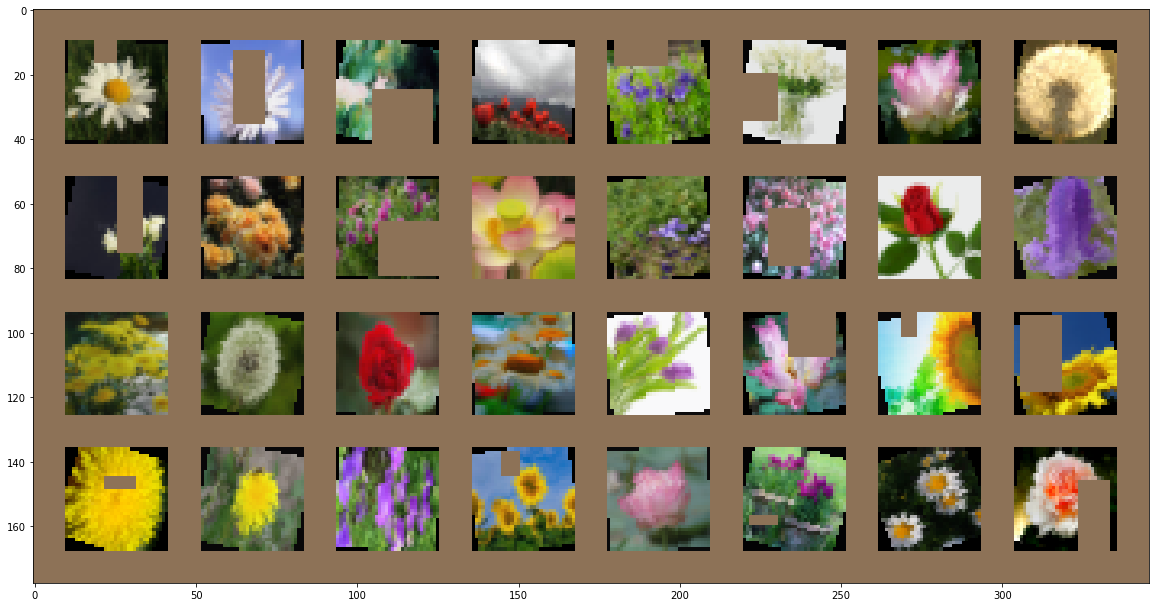

In [96]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)
print(' '.join(f'{classes[targets[j]]:5s}' for j in range(batch_size)))

In [97]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        """self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)"""
        self.fc3 = nn.Linear(7840, 7)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        #x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = nn.functional.relu(self.fc1(x))
        x = self.fc3(x)
        #x = self.fc3(x)
        return x


net = Net()

"""input 16*16*3
CN1   5*5*10
Output 12 * 12 * 10
FC    250 *  7"""


'input 16*16*3\nCN1   5*5*10\nOutput 12 * 12 * 10\nFC    250 *  7'

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [99]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.080
[1,   200] loss: 0.069
[1,   300] loss: 0.067
Finished Training


GroundTruth:  Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus Lotus


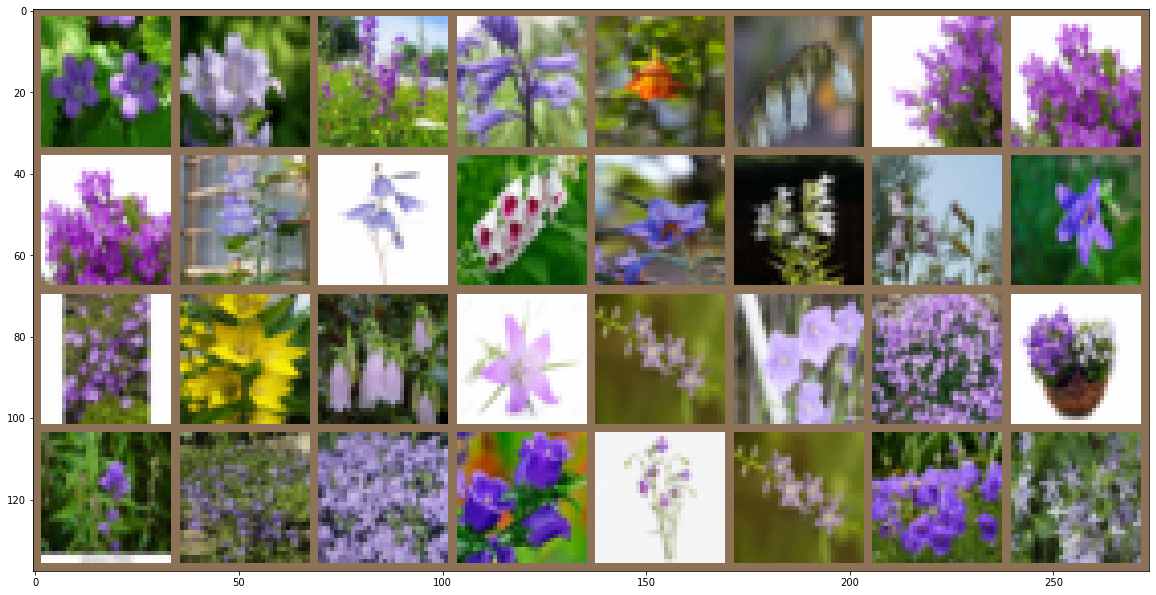

In [100]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images),mean,std)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [101]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 54 %
